## Classification with Python

Hopefully now you are feeling a bit more comfortable with Python, Kaggle, and modeling. 

This next homework will test your classification abilities. We will be trying to predict whether a person survived the Titantic:

https://www.kaggle.com/c/titanic

The evalution metric for Kaggle is accuracy, but please also explore how well your model does on multiple metrics like F1, precision, recall, and area under the ROC curve.

### Grading

This homework is due **March 8, 2018 by midnight Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model evaluation: Did you evaluate your model on multiple metrics? Where does your model do well? Where could it be improved? How are the metrics different?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

## Introduction

In 1912, the RMS Titanic was the largest passenger ship the world had ever seen. Unfortunately, it met an untimely demise on its maiden voyage after bumping into an iceburg. Of the 2,224 passengers, only 722 survived. The tragedy lead to nautical policy reform regarding ship safety regulations. The following project uses Kaggle data to build classification models to predict Titanic survivors.

## Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,8]

### Import Data

In [2]:
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

In [3]:
traindf.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Data Exploration and Cleaning

The training data has 891 observations and is about twice as large as the test set, which only has 418 observations. The test data has one less column since it excludes the dependent 'Survived' variable.

In [4]:
traindf.shape

(891, 12)

In [5]:
testdf.shape

(418, 11)

**Null Values**

In [6]:
# The following function locates the columns with null values and stores the column names in the 'null' array
def nulls():
    null = traindf.columns[traindf.isnull().any()]
    return null

In [7]:
print("Column\t   Nulls")
traindf[nulls()].isnull().sum() # Displays the columns with null values and the total number of null values for each

Column	   Nulls


Age         177
Cabin       687
Embarked      2
dtype: int64

Of the 11 independent columns, 3 have null values. The categorical column 'Embarked' only has 2 missing values out of 891, so it makes sense to fill these nulls with the most common value. 'Age' and 'Cabin' have about 19% and 77% null values respectively. Since these two variables have so many nulls, I will investigate them further and decide whether to impute, transform, or drop these features.

I will first deal with 'Age', Cabin, and 'Embarked' before moving on to the other variables

**Age**

In [8]:
traindf.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

The distribution and description of age seem in line with historical statistics (U.S. Census Bureau and the Monthly Labor Review). Since null values consist of about 19% of the age data, it does not seem unreasonable to impute the nulls with the mean age. 

In [9]:
train_mean_age = traindf.Age.mean() # Saves the mean age of the training data to be used in test data cleaning
traindf.Age.fillna(traindf["Age"].mean(), inplace=True)

Text(0.5,1,'Age Distribution')

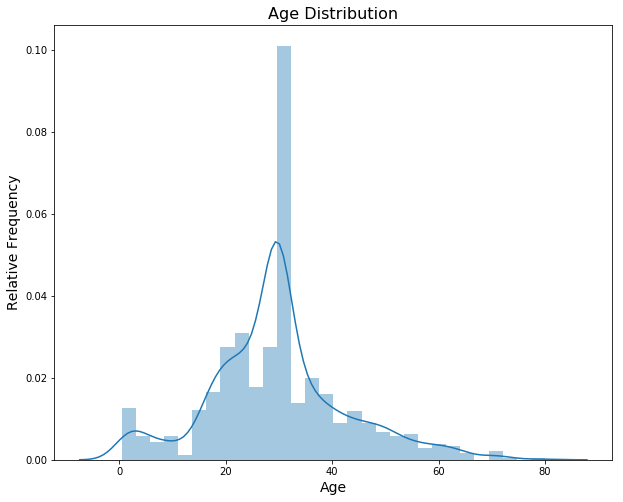

In [10]:
sns.distplot(traindf.Age)
plt.ylabel("Relative Frequency", fontsize=14)
plt.xlabel("Age", fontsize=14)
plt.title("Age Distribution", fontsize=16)

The distribution of age appears to be roughly normal with the exception of the spike at the mean, which comes from the imputed null values.

**Cabin**

In [11]:
traindf.Cabin.describe()

count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object

With 687 null values out of 891 total, 'Cabin' appears to hold very little information. To get a better idea of what to do with this feature, I will engineer it to be more easily analyzed. I do this by extracting and assigning only the cabin letter to each observation; this effectively transforms 'Cabin' into a more meaningful categorical variable. No real information is lost because room number is extraneous, but the room letter likely signifies a group of some sort. For example, rooms sharing the same letter could also share similar characteristis such as  multiple windows or a balcony. To see if there is some systematic difference about cabin letter groups, I will plot ticket fare against cabin letter. If the fare price distributions are the same across cabin letter groups, then cabin letter likely does not indicate any meaningful relationship between 'Cabin' and the other variables, which would justify dropping it from the data.

In [12]:
cabin_levels = ['A','B','C','D','E','F','G','T']
filtered_data = traindf.dropna(subset=['Cabin']).copy()
filtered_data.Cabin = filtered_data.Cabin.apply(lambda x: str(x)[0])
traindf.Cabin = traindf.Cabin.apply(lambda x: str(x)[0] if str(x)[0] in cabin_levels else 'NaN')

Text(0.5,1,'Fare Price Distribution by Cabin\n $\\it{excluding}$ $\\it{nulls}$')

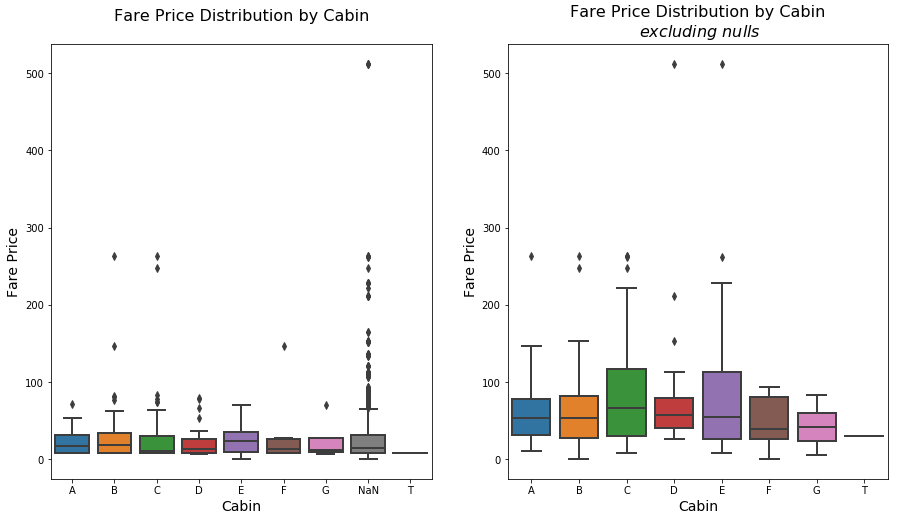

In [13]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.boxplot(x=sorted(traindf["Cabin"]), y=traindf["Fare"], linewidth=2)
plt.xlabel("Cabin", fontsize=14)
plt.ylabel("Fare Price", fontsize=14)
plt.title("Fare Price Distribution by Cabin\n", fontsize=16)

plt.subplot(1,2,2)
sns.boxplot(x=sorted(filtered_data["Cabin"]), y=filtered_data["Fare"], linewidth=2)
plt.xlabel("Cabin", fontsize=14)
plt.ylabel("Fare Price", fontsize=14)
plt.title("Fare Price Distribution by Cabin\n $\it{excluding}$ $\it{nulls}$", fontsize=16)

As hypothesized above, the cabin letter groups do not appear to systematically differ from one another in either graph. Note that I use 'Fare Price' as a proxy for cabin similarity since the ticket price strongly correlates with room characteristics. Admittedly, the 'NaN' data almost certainly distorts the distributions since its magnitude is larger than all the other categories combined. However when the 'NaN' values are excluded, the cabin groups are still very similar. Thus, it seems prudent to drop this variable.

**Ticket**

Text(0,0.5,'Fare Price ($)')

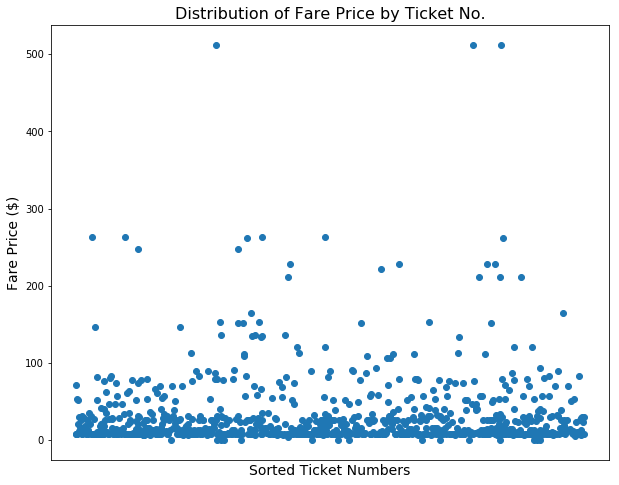

In [14]:
plt.scatter(sorted(traindf.Ticket),traindf.Fare) # Makes a scatter plot Fare against Ticket number 
plt.xticks([])
plt.title("Distribution of Fare Price by Ticket No.", fontsize=16)
plt.xlabel("Sorted Ticket Numbers", fontsize=14)
plt.ylabel("Fare Price ($)", fontsize=14)

The above graph displays the 'Fare Price' by 'Ticket'. By sorting the ticket numbers, I was able to see that there is no correlation between ticket number and 'Fare Price'. Since 'Ticket' is little more than an arbitrary identifier as illustrated by the random noise above, I will drop it from the data.

**Gender**

In [15]:
traindf.Sex.value_counts(dropna=False)

male      577
female    314
Name: Sex, dtype: int64

The gender variables are currently stored as strings ('male' and 'female'), so I will encode them as 1 for males and 0 for females. To ensure that the encoding works properly, I look at the 871 row before and after the transformation.

In [16]:
traindf.iloc[871][0:5] # Returns information on the 872nd passenger

PassengerId                                                 872
Survived                                                      1
Pclass                                                        1
Name           Beckwith, Mrs. Richard Leonard (Sallie Monypeny)
Sex                                                      female
Name: 871, dtype: object

In [17]:
traindf.Sex = traindf.Sex.apply(lambda x: 1 if x == 'male' else 0) # Encodes 'male' as 1 and 'female' as 0

**Embarked**

In [18]:
traindf.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [19]:
traindf.fillna(traindf['Embarked'].value_counts().index[0], inplace=True) # Fills the nulls with the column mode, 'S'

In [20]:
traindf = pd.get_dummies(traindf, columns=["Embarked"]) # Creates dummy columns for each of the 3 boarding locations

In [21]:
traindf.iloc[871][0:5] # Returns information on the 872nd passenger

PassengerId                                                 872
Survived                                                      1
Pclass                                                        1
Name           Beckwith, Mrs. Richard Leonard (Sallie Monypeny)
Sex                                                           0
Name: 871, dtype: object

Looking at the sex of passenger 872, female was accurately encoded as 0, verifying that the values were encoded correctly.

**Data Cleaning Recap:**

**Transformed Variables**

- Sex- This variable is a string consisting of 'male' and 'female', which I transformed to 1 for male and 0 for female
- Embarked- For this feature, I created dummy variables for each of the 3 locations indicating from where someone boarded the ship.

**Imputed Variables**
- Age- There are 177 null values that I imputed with the mean.

**Dropped Variables**

- PassengerId- As an arbitrary identifier, it provides no predictive power.
- Name- This variable is also an arbitrary identifier. For those individuals with titles such as "Dr." or "Sir", their ticket price reflects their elevated status.
- Ticket- This variable is also an arbitrary identifier, as evidenced by the fare price and ticket number scatter plot.
- Cabin- With more than 77% missing values, this feature was too sparse to include in the models.

In [22]:
traindf.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

### Modeling

In [23]:
target = traindf.Survived
traindf.drop(["Survived"], axis=1, inplace=True)

In [24]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [25]:
xtrain, xtest, ytrain, ytest = train_test_split(traindf, target, test_size=0.2, random_state=42)

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = scaler.transform(xtrain)

**K-Neighbors Classifier**

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [29]:
kn_clf = KNeighborsClassifier()

In [30]:
gridsearch_kn = GridSearchCV(kn_clf, {"n_neighbors": [1,3,5,7,9,11], "weights": ['uniform', 'distance'],
                                  "p":[1,2,3]}, scoring='f1')
gridsearch_kn.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_kn.best_params_))
knclf_ypredict_train = gridsearch_kn.predict(xtrain)
print("Training F1 Score: {}".format(f1_score(ytrain, knclf_ypredict_train)))

print("Test Classification Report:")
knclf_ypredict_test = gridsearch_kn.predict(xtest)
print(classification_report(ytest, knclf_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(accuracy_score(ytrain, knclf_ypredict_train), 
                                                     accuracy_score(ytest, knclf_ypredict_test)))

Best Parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Training F1 Score: 0.9732824427480916
Test Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.86      0.79       105
          1       0.73      0.55      0.63        74

avg / total       0.73      0.73      0.72       179

Train Accuracy: 0.9803370786516854
Test Accuracy: 0.7318435754189944


**Random Forest**

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf_clf = RandomForestClassifier()
gridsearch_rf = GridSearchCV(rf_clf, {"n_estimators": [1000, 2500, 5000], "class_weight": ['balanced', None],
                                      "max_depth": [1,3,5,7,9,11]}, scoring='f1')
gridsearch_rf.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_rf.best_params_))
rfclf_ypredict_train = gridsearch_rf.predict(xtrain)
print("Training F1 Score: {}".format(f1_score(ytrain, rfclf_ypredict_train)))

print("Test Classification Report:")
rfclf_ypredict_test = gridsearch_rf.predict(xtest)
print(classification_report(ytest, rfclf_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(accuracy_score(ytrain, rfclf_ypredict_train),
                                                    accuracy_score(ytest, rfclf_ypredict_test)))

Best Parameters: {'class_weight': 'balanced', 'max_depth': 7, 'n_estimators': 5000}
Training F1 Score: 0.8622047244094487
Test Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.88      0.84       105
          1       0.80      0.72      0.76        74

avg / total       0.81      0.81      0.81       179

Train Accuracy: 0.901685393258427
Test Accuracy: 0.8100558659217877


### Test Predictions

In [35]:
# Runs same transformations on test data as the training data
testdf.Age.fillna(train_mean_age, inplace=True)
testdf.Fare.fillna(traindf.Fare.mean(), inplace=True)
testdf.Sex = testdf.Sex.apply(lambda x: 1 if x == 'male' else 0)
test_id = testdf.PassengerId # Saves the test data id numbers
testdf = pd.get_dummies(testdf, columns=["Embarked"])
testdf.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

In [36]:
testdf.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,1,34.5,0,0,7.8292,0,1,0
1,3,0,47.0,1,0,7.0000,0,0,1
2,2,1,62.0,0,0,9.6875,0,1,0
3,3,1,27.0,0,0,8.6625,0,0,1
4,3,0,22.0,1,1,12.2875,0,0,1


In [37]:
predictions = gridsearch_rf.best_estimator_.predict(testdf)

In [38]:
submission = test_id.to_frame()
submission['Survived'] = predictions

In [39]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
submission.to_csv("submission3.csv", index=False)